### 1. 🐝 Overview

This project prepares a custom dataset for detecting **Worker Bees (class 0)** and **Drone Bees (class 1)** from ultra-wide images extracted from video frames. The original data set is found from **Mississippi State University**.

The **source images** have a resolution of **3840 × 1080**.
Training YOLO directly on this extreme aspect ratio would cause heavy **downscaling**, which leads to loss of detail and poor detection accuracy for small objects like bees.

To solve this, the dataset is automatically sliced into **3 tiles per image**, each with **1280 × 1080** resolution.
This keeps the bee size large for YOLO while maintaining reasonable memory usage.

#### **Notice:**
Since the tiles are 1280×1080, we must train YOLO with: <span style="color:red">**imgsz=1280**</span>

In [25]:
import matplotlib.pyplot as plt
from pathlib import Path
import json
from tqdm import tqdm
import cv2

I convert all LabelMe JSON annotations into YOLO-format text files for training an object detection model. It merges the two worker-bee classes ('Worker-Bee-Pollen' and 'Worker-Bee-No-Pollen') into a single class (0) and assigns drone bees to class (1).

In [26]:
# Configuration
dataset_path = Path(r'\json') # insert your own path
output_path = Path(r'\yolo') # insert your own path
output_path.mkdir(exist_ok=True)

json_files = list(dataset_path.glob('*.json'))

# Simple 2-class mapping
class_mapping = {
    'Worker-Bee-Pollen': 0,      
    'Worker-Bee-No-Pollen': 0,   
    'Drone-Bee': 1
}

def convert_xyxy2xywh(points, w, h):
    """Convert bounding box from corner format to YOLO format"""
    x1 = points[0][0]
    x2 = points[1][0]
    y1 = points[0][1]
    y2 = points[1][1]
    
    # YOLO format: center_x, center_y, width, height (all normalized 0-1)
    center_x = ((x1 + x2) / 2) / w
    center_y = ((y1 + y2) / 2) / h
    width = abs(x2 - x1) / w
    height = abs(y2 - y1) / h
    
    return center_x, center_y, width, height

def convert_labelme2yolo(json_path):
    """Convert single LabelMe JSON to YOLO format"""
    with open(json_path, 'r') as f:
        label_json = json.load(f)
    
    img_width = label_json['imageWidth']
    img_height = label_json['imageHeight']
    
    # Create output txt file
    txt_filename = json_path.stem + '.txt'
    txt_path = output_path / txt_filename
    
    yolo_lines = []
    
    for shape in label_json['shapes']:
        label_name = shape['label']
        
        # Map label to class ID
        if label_name not in class_mapping:
            print(f"Warning: Unknown label '{label_name}' in {json_path.name}")
            continue
        
        class_id = class_mapping[label_name]
        
        # Convert coordinates
        x, y, w, h = convert_xyxy2xywh(shape['points'], img_width, img_height)
        
        # Format: class_id center_x center_y width height
        yolo_lines.append(f"{class_id} {x} {y} {w} {h}")
    
    # Write to file
    with open(txt_path, 'w') as f:
        f.write('\n'.join(yolo_lines))

# Main conversion
print("Converting LabelMe JSON to YOLO format...")
print(f"Found {len(json_files)} JSON files")
print("\nClass mapping:")
print("  0: Worker-Bee")
print("  1: Drone-Bee")
print()

stats = {'worker': 0, 'drone': 0}

for json_file in tqdm(json_files, desc="Converting"):
    convert_labelme2yolo(json_file)
    
    # Count classes
    txt_file = output_path / (json_file.stem + '.txt')
    if txt_file.exists():
        with open(txt_file, 'r') as f:
            for line in f:
                class_id = int(line.split()[0])
                if class_id == 0:
                    stats['worker'] += 1
                elif class_id == 1:
                    stats['drone'] += 1

print("\n" + "="*50)
print("Conversion Complete!")
print("="*50)
print(f"Worker Bees: {stats['worker']:,}")
print(f"Drone Bees: {stats['drone']:,}")
if stats['drone'] > 0:
    print(f"Ratio (Worker:Drone): {stats['worker']/stats['drone']:.2f}:1")

Converting LabelMe JSON to YOLO format...
Found 365 JSON files

Class mapping:
  0: Worker-Bee
  1: Drone-Bee



Converting: 100%|████████████████████████████████████████████████████████████████████| 365/365 [00:06<00:00, 53.26it/s]


Conversion Complete!
Worker Bees: 7,767
Drone Bees: 540
Ratio (Worker:Drone): 14.38:1


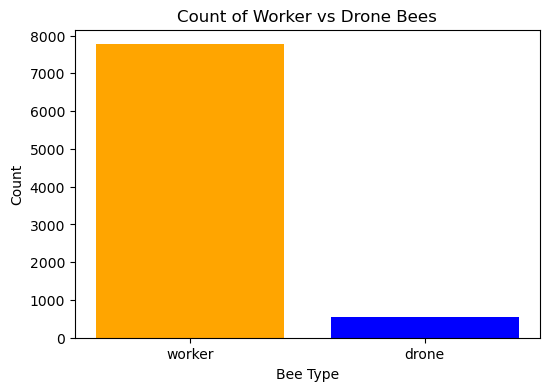

In [7]:
labels = list(stats.keys())
counts = list(stats.values())
colors = ["orange", "blue"]

plt.figure(figsize=(6, 4))
plt.bar(labels, counts, color = colors)
plt.xlabel("Bee Type")
plt.ylabel("Count")
plt.title("Count of Worker vs Drone Bees")
plt.show()

Here I checked each image and its YOLO label file to detect whether any bees appear within the last 256 pixels on the right side of the image.

In [15]:
IMAGE_FOLDER = Path(r"\images") # insert your own path
LABEL_FOLDER = Path(r"\yolo") # insert your own path

EDGE = 256
results = {}  # store info per image
worker_count = 0
drone_count = 0

for img_path in IMAGE_FOLDER.glob("*.jpg"):
    label_path = LABEL_FOLDER / (img_path.stem + ".txt")

    img = cv2.imread(str(img_path))
    if img is None:
        continue

    h, w = img.shape[:2]
    edge_start = w - EDGE

    worker_in_edge = False
    drone_in_edge = False

    if label_path.exists():
        with open(label_path, "r") as f:
            for line in f:
                class_id, cx, cy, bw, bh = line.strip().split()
                class_id = int(class_id)

                cx = float(cx) * w
                bw = float(bw) * w

                # bounding box left and right edges
                x1 = cx - bw/2
                x2 = cx + bw/2

                # check intersection with last 20px region
                if x2 >= edge_start:
                    if class_id == 0:
                        worker_in_edge = True
                        worker_count += 1
                    elif class_id == 1:
                        drone_in_edge = True
                        drone_count += 1

    results[img_path.name] = {
        "worker": worker_in_edge,
        "drone": drone_in_edge
    }

print(f"Worker bees touching last 256px: {worker_count}")
print(f"Drone bees touching last 256px: {drone_count}")
print(f"Total images checked: {len(results)}\n")

Worker bees touching last 256px: 318
Drone bees touching last 256px: 2
Total images checked: 364



YOLO internally resizes all images to imgsz **(default: 640)**.
If YOLO resized a 3840px-wide image to 640px:
1. Each bee becomes extremely small
2. Detections become inaccurate or impossible
3. Model cannot learn fine details

So I sliced the images into three overlapping tiles:

Tile 0 → 0–1280 px  
Tile 1 → 1152–2432 px  
Tile 2 → 2304–3584 px

The last 256px on the far right are intentionally removed because they mostly contained worker-only detections and removing them helps balance the dataset.

In [23]:
def slice_image(image, tile_width=1280, overlap=128):
    # h = 1080, w = 3840
    h, w = image.shape[:2]

    stride = tile_width - overlap
    # These are the left edges of each tile.
    positions = list(range(0, w - tile_width + 1, stride))
    tiles = [(image[:, x:x+tile_width], x) for x in positions]
    return tiles
    
def slice_dataset(
    img_folder,
    label_folder,
    output_img_folder,
    output_label_folder,
    tile_width=1280,
    overlap=128
):
    img_dir = Path(img_folder)
    label_dir = Path(label_folder)

    out_img = Path(output_img_folder)
    out_lbl = Path(output_label_folder)

    out_img.mkdir(parents=True, exist_ok=True)
    out_lbl.mkdir(parents=True, exist_ok=True)

    # get all image files
    images = list(img_dir.glob("*.jpg")) + list(img_dir.glob("*.png"))

    for img_path in tqdm(images):
        img = cv2.imread(str(img_path))
        h, w = img.shape[:2]

        # find matching YOLO label
        label_path = label_dir / (img_path.stem + ".txt")

        # load YOLO labels
        labels = []
        if label_path.exists():
            with open(label_path, "r") as f:
                labels = [l.split() for l in f]

        # slice image into tiles
        tiles = slice_image(img, tile_width, overlap)

        # process each tile
        for idx, (tile, x0) in enumerate(tiles):
            th, tw = tile.shape[:2]

            # save tile image
            tile_name = f"{img_path.stem}_tile{idx}{img_path.suffix}"
            cv2.imwrite(str(out_img / tile_name), tile)

            # adjust labels for this tile
            new_labels = []
            for lbl in labels:
                class_id = lbl[0]

                cx = float(lbl[1]) * w
                cy = float(lbl[2]) * h
                bw = float(lbl[3]) * w
                bh = float(lbl[4]) * h

                x1, x2 = cx - bw/2, cx + bw/2

                # check if bbox intersects tile
                if x2 > x0 and x1 < x0 + tw:
                    cx_new = (cx - x0) / tw
                    cy_new = cy / th
                    bw_new = bw / tw
                    bh_new = bh / th

                    new_labels.append(
                        f"{class_id} {cx_new:.6f} {cy_new:.6f} {bw_new:.6f} {bh_new:.6f}"
                    )

            # write tile labels
            with open(out_lbl / f"{img_path.stem}_tile{idx}.txt", "w") as f:
                f.write("\n".join(new_labels))


In [24]:
slice_dataset(
    img_folder=r"\images", # insert your own path
    label_folder=r"\yolo", # insert your own path
    output_img_folder=r"\sliced\images", # insert your own path
    output_label_folder=r"\sliced\labels", # insert your own path
    tile_width=1280,
    overlap=128
)

100%|████████████████████████████████████████████████████████████████████████████████| 364/364 [00:52<00:00,  7.00it/s]
